# **Weights & Biases Tutorial**


*   By BHAVANA RAJAN NAIR

I highly recomend you to follow each section in order as explatations to each feature is added to the respective section where it is introduced. The dinal section is a cascaded form of all the other section where each feature is build on top the previous section.




The aim of this tutorial is a simple Weights & Biases introduction using the classic handwritten digit classifier. The tutorial is 3 sections


*   A simple project integrated with wandb
*   Usage of wandb sweep for hyperparameter tuning
*  Enhancement with wandb allerts



# **COMMON SECTION**

In [1]:
%%capture
!pip install wandb

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import tqdm

First we need to create a wandb account to bring up an instance. Once the account is in place, login to the account. Further integration happens in the following steps

In [3]:
wandb.login()

wandb: Currently logged in as: bhavananair (bhavanarajannair). Use `wandb login --relogin` to force relogin


True

# **Now to some basic ML steps**

*   Data processing
*   Model creation
*   Training step



In [4]:
# Prepare the training dataset
BATCH_SIZE = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# build input pipeline using tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)

In [5]:
def make_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x1 = keras.layers.Dense(64, activation="relu")(inputs)
    x2 = keras.layers.Dense(64, activation="relu")(x1)
    outputs = keras.layers.Dense(10, name="predictions")(x2)

    return keras.Model(inputs=inputs, outputs=outputs)

Loss calculation in each iteration of train and test.

In [6]:
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

In [7]:
def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

# **SECTION 1**

This is a simple training step with an additional log entry to wandb.

These lines ensure that the loss and accuracy values are logged to wandb dynamically.

```
   wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc),
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})
```



In [8]:
def train(train_dataset, val_dataset,  model, optimizer,
          train_acc_metric, val_acc_metric,
          epochs=10,  log_step=200, val_log_step=50):

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train,
                                    model, optimizer,
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val,
                                       model, loss_fn,
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))

        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc),
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

To log the details into wandb, we need to bring up a session by initializing a project followed by training the model. The following steps happen

*   Configure the wandb project by specifying the hyperparameters.
*   initialize the project
*   Create model
*   initialize the optimizer, loss and metrics
*   Train the model




In [9]:
# initialize wandb with your project name and optionally with configutations.
# play around with the config values and see the result on your wandb dashboard.
config = {
              "learning_rate": 0.001,
              "epochs": 5,
              "batch_size": 64,
              "log_step": 200,
              "val_log_step": 50,
              "architecture": "CNN",
              "dataset": "CIFAR-10"
           }

run = wandb.init(project='my-wand', config=config)
config = wandb.config

# Initialize model.
model = make_model()

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=config.learning_rate)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

train(train_dataset,
      val_dataset,
      model,
      optimizer,
      train_acc_metric,
      val_acc_metric,
      epochs=config.epochs,
      log_step=config.log_step,
      val_log_step=config.val_log_step)

run.finish()  # In Jupyter/Colab, let us know you're finished!


Start of epoch 0
Training acc over epoch: 0.7534
Validation acc: 0.8413

Start of epoch 1
Training acc over epoch: 0.8565
Validation acc: 0.8786

Start of epoch 2
Training acc over epoch: 0.8844
Validation acc: 0.8925

Start of epoch 3
Training acc over epoch: 0.8986
Validation acc: 0.8998

Start of epoch 4
Training acc over epoch: 0.9086
Validation acc: 0.9058


acc,▁▆▇██
epochs,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▇▇█
val_loss,█▄▃▁▁
acc,0.90865
epochs,4
loss,0.32278
val_acc,0.9058
val_loss,0.35524


It is possible to see different visualizations in the W&B console. These plots are automatically populated for each run.
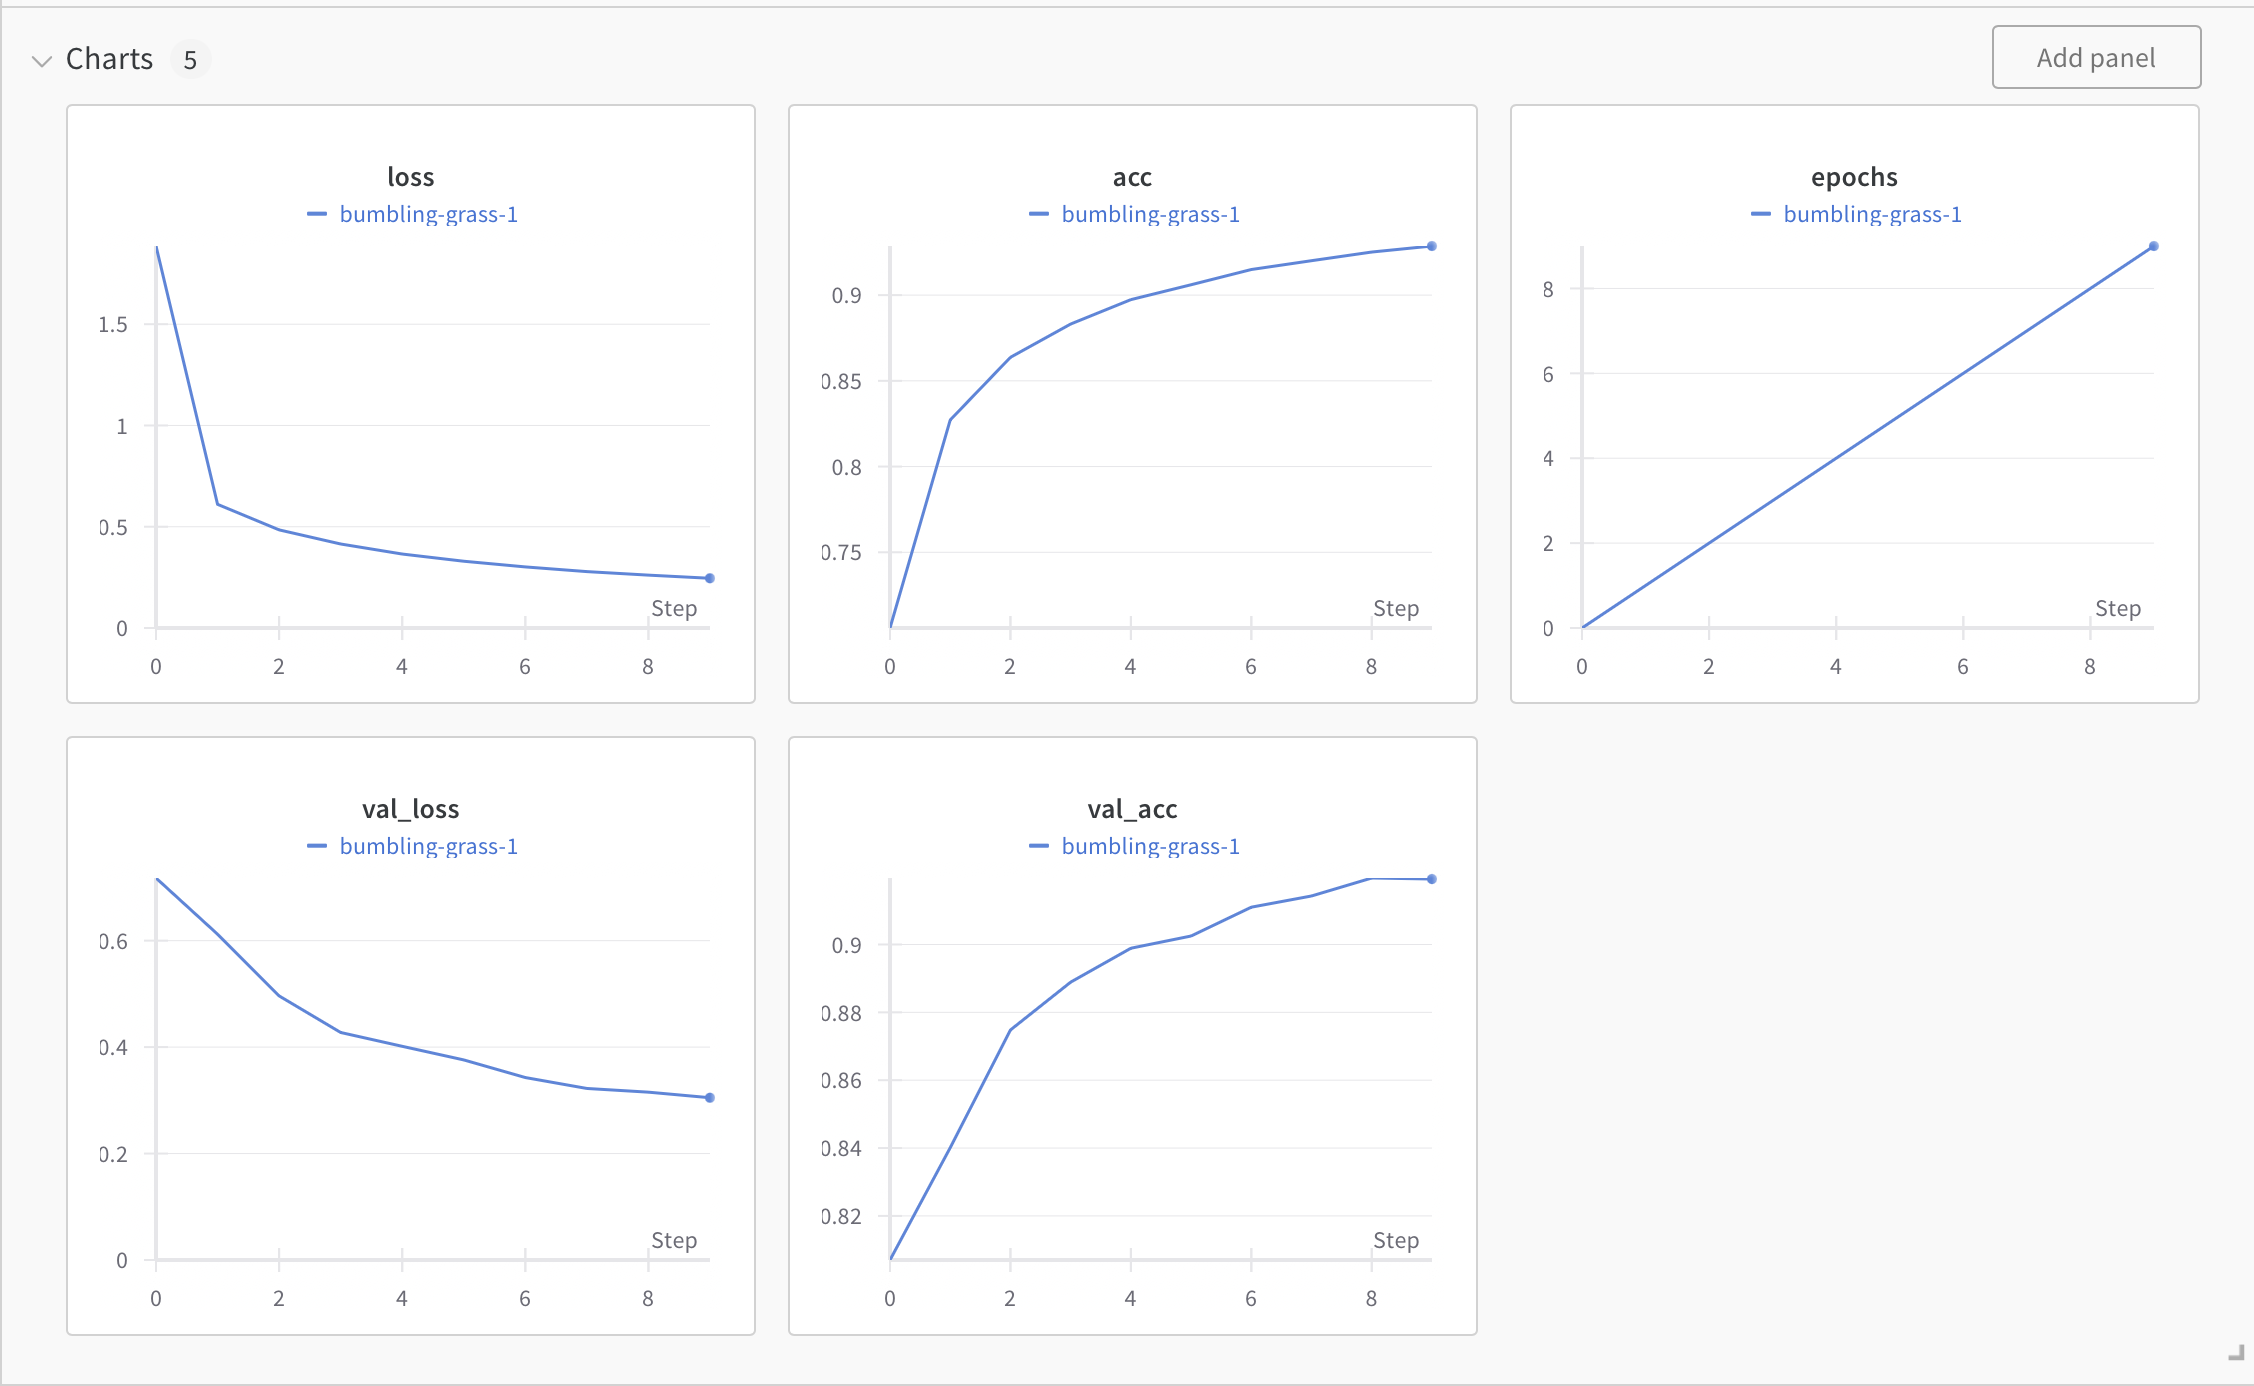

# **SECTION 2**

# **Using SWEEP**

Sweeps automates hyperparameter search and visualize rich, interactive experiment tracking. It accepts a list of different hyperparameters and figures out the best combination of those that results in the best output.

In [10]:
def train(train_dataset,
          val_dataset,
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=10,
          log_step=200,
          val_log_step=50):

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss_value = train_step(x_batch_train, y_batch_train,
                                    model, optimizer,
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val,
                                       model, loss_fn,
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))

        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc),
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

In [11]:
sweep_config = {
  'method': 'random',
  'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'batch_size': {
          'values': [32, 64, 128, 256]
      },
      'learning_rate':{
          'values': [0.01, 0.005, 0.001, 0.0005, 0.0001]
      }
  }
}

In [12]:
def sweep_train(config_defaults=None):
    # Set default values
    config_defaults = {
        "batch_size": 64,
        "learning_rate": 0.01
    }
    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)  # this gets over-written in the Sweep

    # Specify the other hyperparameters to the configuration, if any
    wandb.config.epochs = 5
    wandb.config.log_step = 20
    wandb.config.val_log_step = 50
    wandb.config.architecture_name = "MLP"
    wandb.config.dataset_name = "MNIST"

    # build input pipeline using tf.data
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = (train_dataset.shuffle(buffer_size=1024)
                                  .batch(wandb.config.batch_size)
                                  .prefetch(buffer_size=tf.data.AUTOTUNE))

    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = (val_dataset.batch(wandb.config.batch_size)
                              .prefetch(buffer_size=tf.data.AUTOTUNE))

    # initialize model
    model = make_model()

    # Instantiate an optimizer to train the model.
    optimizer = keras.optimizers.SGD(learning_rate=wandb.config.learning_rate)
    # Instantiate a loss function.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Prepare the metrics.
    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

    train(train_dataset,
          val_dataset,
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=wandb.config.epochs,
          log_step=wandb.config.log_step,
          val_log_step=wandb.config.val_log_step)

In [13]:
sweep_id = wandb.sweep(sweep_config, project="my-wand")

Create sweep with ID: 1mm71clj
Sweep URL: https://wandb.ai/bhavanarajannair/my-wand/sweeps/1mm71clj


In [14]:
wandb.agent(sweep_id, function=sweep_train, count=5)

wandb: Agent Starting Run: zxlv4zhc with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005



Start of epoch 0


100%|██████████| 469/469 [00:10<00:00, 45.74it/s]


Training acc over epoch: 0.7137
Validation acc: 0.7619

Start of epoch 1


100%|██████████| 469/469 [00:10<00:00, 45.37it/s]


Training acc over epoch: 0.7904
Validation acc: 0.8185

Start of epoch 2


100%|██████████| 469/469 [00:10<00:00, 46.13it/s]


Training acc over epoch: 0.8318
Validation acc: 0.8424

Start of epoch 3


100%|██████████| 469/469 [00:09<00:00, 50.63it/s]


Training acc over epoch: 0.8551
Validation acc: 0.8586

Start of epoch 4


100%|██████████| 469/469 [00:09<00:00, 49.22it/s]


Training acc over epoch: 0.8698
Validation acc: 0.8687


acc,▁▄▆▇█
epochs,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▅▆▇█
val_loss,█▄▂▂▁
acc,0.86985
epochs,4
loss,0.49992
val_acc,0.8687
val_loss,0.49718


wandb: Agent Starting Run: cc395fys with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001



Start of epoch 0


100%|██████████| 1875/1875 [00:40<00:00, 46.69it/s]


Training acc over epoch: 0.7475
Validation acc: 0.8403

Start of epoch 1


100%|██████████| 1875/1875 [00:39<00:00, 47.90it/s]


Training acc over epoch: 0.8595
Validation acc: 0.8832

Start of epoch 2


100%|██████████| 1875/1875 [00:37<00:00, 49.83it/s]


Training acc over epoch: 0.8881
Validation acc: 0.8979

Start of epoch 3


100%|██████████| 1875/1875 [00:38<00:00, 49.23it/s]


Training acc over epoch: 0.9026
Validation acc: 0.8861

Start of epoch 4


100%|██████████| 1875/1875 [00:42<00:00, 44.57it/s]


Training acc over epoch: 0.9128
Validation acc: 0.9105


acc,▁▆▇██
epochs,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▇▆█
val_loss,█▄▂▃▁
acc,0.91275
epochs,4
loss,0.31123
val_acc,0.9105
val_loss,0.36276


wandb: Agent Starting Run: x1xaymul with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.001



Start of epoch 0


100%|██████████| 235/235 [00:05<00:00, 44.17it/s]


Training acc over epoch: 0.7393
Validation acc: 0.8178

Start of epoch 1


100%|██████████| 235/235 [00:05<00:00, 43.44it/s]


Training acc over epoch: 0.8285
Validation acc: 0.8320

Start of epoch 2


100%|██████████| 235/235 [00:04<00:00, 47.63it/s]


Training acc over epoch: 0.8515
Validation acc: 0.8597

Start of epoch 3


100%|██████████| 235/235 [00:06<00:00, 38.43it/s]


Training acc over epoch: 0.8667
Validation acc: 0.8700

Start of epoch 4


100%|██████████| 235/235 [00:05<00:00, 42.14it/s]


Training acc over epoch: 0.8769
Validation acc: 0.8662


acc,▁▆▇▇█
epochs,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▃▇█▇
val_loss,█▄▂▁▁
acc,0.87692
epochs,4
loss,0.47174
val_acc,0.8662
val_loss,0.51051


wandb: Agent Starting Run: 71idh10a with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0005



Start of epoch 0


100%|██████████| 938/938 [00:19<00:00, 47.27it/s]


Training acc over epoch: 0.7730
Validation acc: 0.8462

Start of epoch 1


100%|██████████| 938/938 [00:19<00:00, 48.83it/s]


Training acc over epoch: 0.8546
Validation acc: 0.8580

Start of epoch 2


100%|██████████| 938/938 [00:19<00:00, 48.79it/s]


Training acc over epoch: 0.8787
Validation acc: 0.8867

Start of epoch 3


100%|██████████| 938/938 [00:19<00:00, 47.10it/s]


Training acc over epoch: 0.8925
Validation acc: 0.8796

Start of epoch 4


100%|██████████| 938/938 [00:18<00:00, 49.39it/s]


Training acc over epoch: 0.9031
Validation acc: 0.9020


acc,▁▅▇▇█
epochs,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▂▆▅█
val_loss,█▅▂▂▁
acc,0.90313
epochs,4
loss,0.35947
val_acc,0.902
val_loss,0.38804


wandb: Agent Starting Run: p2cokcj4 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.005



Start of epoch 0


100%|██████████| 1875/1875 [00:39<00:00, 47.03it/s]


Training acc over epoch: 0.1129
Validation acc: 0.1149

Start of epoch 1


100%|██████████| 1875/1875 [00:38<00:00, 48.58it/s]


Training acc over epoch: 0.1130
Validation acc: 0.1137

Start of epoch 2


100%|██████████| 1875/1875 [00:38<00:00, 49.29it/s]


Training acc over epoch: 0.1124
Validation acc: 0.1138

Start of epoch 3


100%|██████████| 1875/1875 [00:39<00:00, 48.03it/s]


Training acc over epoch: 0.1124
Validation acc: 0.1138

Start of epoch 4


100%|██████████| 1875/1875 [00:38<00:00, 48.80it/s]


Training acc over epoch: 0.1137
Validation acc: 0.1305


acc,▄▄▁▁█
epochs,▁▃▅▆█
loss,█▁▁▁▁
val_acc,▁▁▁▁█
val_loss,████▁
acc,0.11368
epochs,4
loss,2.29953
val_acc,0.1305
val_loss,2.27123


# **SECTION 3**

# **With W&B Alerts**

While wandb tries to find the best parameter combinations, it iteratively goes through different combinations. Some of them whould be good and some bad. As we see in the below results, even in the last iteration the acculacy is below 50%, which is very less.

Wand be provides tools to avaid these wasteful computations by preventing further iterations if the mecric under consideration is below a certain threshold.

W&B Alerts allows you to send alerts, to your Slack or email. There are 2 steps to follow:

1) Turn on Alerts in your W&B User Settings

2) Add wandb.alert() to your code:

Both these happen inside the train step as we need to break each training iteration if the metric is below a certain acceptable range.

```
Start of epoch 9
100%|██████████| 235/235 [00:04<00:00, 49.83it/s]
Training acc over epoch: 0.4049
Validation acc: 0.4129
```



In [15]:
def train(train_dataset,
          val_dataset,
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=2,
          log_step=200,
          val_log_step=50,
          callbacks=None):

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss_value = train_step(x_batch_train, y_batch_train,
                                    model, optimizer,
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val,
                                       model, loss_fn,
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))

        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # 3️⃣ log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc),
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

        wandb.alert(
            title="Low accuracy",
            text=f"Accuracy is below the acceptable threshold"
        )
        threshold = 0.6
        acc = val_acc

        if acc <= threshold:
        # Send the wandb Alert
          wandb.alert(
              title='Low Accuracy',
              text=f'Accuracy {acc} at step {epoch} is below the acceptable theshold, {threshold}',
          )
          print('Alert triggered')
          break

**If section 2 is not run/ you restarted the session after section 2, please run the following cells in section 2:**

---



*   sweep_config
*   sweep_train



use the same configs as in the previous section **"sweep_config"**

In [16]:
sweep_id = wandb.sweep(sweep_config, project="my-wand")

Create sweep with ID: ll4kzihc
Sweep URL: https://wandb.ai/bhavanarajannair/my-wand/sweeps/ll4kzihc


In [17]:
wandb.agent(sweep_id, function=sweep_train, count=5)

wandb: Agent Starting Run: qvugktcc with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.01



Start of epoch 0


100%|██████████| 235/235 [00:05<00:00, 46.52it/s]


Training acc over epoch: 0.1118
Validation acc: 0.1135
Alert triggered


acc,▁
epochs,▁
loss,▁
val_acc,▁
val_loss,▁
acc,0.1118
epochs,0
loss,757.49037
val_acc,0.1135
val_loss,2.30196


wandb: Agent Starting Run: 1h52kre2 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.005



Start of epoch 0


100%|██████████| 938/938 [00:18<00:00, 49.75it/s]


Training acc over epoch: 0.1116
Validation acc: 0.1135
Alert triggered


acc,▁
epochs,▁
loss,▁
val_acc,▁
val_loss,▁
acc,0.1116
epochs,0
loss,6.03549
val_acc,0.1135
val_loss,2.30252


wandb: Agent Starting Run: 7muiqn7y with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.005



Start of epoch 0


100%|██████████| 938/938 [00:18<00:00, 50.18it/s]


Training acc over epoch: 0.2706
Validation acc: 0.3558
Alert triggered


acc,▁
epochs,▁
loss,▁
val_acc,▁
val_loss,▁
acc,0.27058
epochs,0
loss,3.18358
val_acc,0.3558
val_loss,1.70531


wandb: Agent Starting Run: mc458zpn with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.005



Start of epoch 0


100%|██████████| 938/938 [00:19<00:00, 47.38it/s]


Training acc over epoch: 0.2341
Validation acc: 0.3001
Alert triggered


acc,▁
epochs,▁
loss,▁
val_acc,▁
val_loss,▁
acc,0.23405
epochs,0
loss,4.16367
val_acc,0.3001
val_loss,1.8526


wandb: Agent Starting Run: 4uoyk2en with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0001



Start of epoch 0


100%|██████████| 235/235 [00:05<00:00, 46.58it/s]


Training acc over epoch: 0.5077
Validation acc: 0.6503

Start of epoch 1


100%|██████████| 235/235 [00:06<00:00, 37.75it/s]


Training acc over epoch: 0.6904
Validation acc: 0.7227

Start of epoch 2


100%|██████████| 235/235 [00:05<00:00, 45.87it/s]


Training acc over epoch: 0.7420
Validation acc: 0.7572

Start of epoch 3


100%|██████████| 235/235 [00:05<00:00, 39.34it/s]


Training acc over epoch: 0.7687
Validation acc: 0.7756

Start of epoch 4


100%|██████████| 235/235 [00:05<00:00, 46.34it/s]


Training acc over epoch: 0.7856
Validation acc: 0.7885


acc,▁▆▇██
epochs,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▆▇█
val_loss,█▄▂▂▁
acc,0.78562
epochs,4
loss,2.04748
val_acc,0.7885
val_loss,1.85249


# **SECTION 4**

# **With Callbacks**



*   WandbCallback is a callback provided by Weights and Biases which logs all relevant information to wandb, providing a detailed and reproducible record of the experiment.
*   WandbModelCheckpoint saves model checkpoints to both your local storage and the wandb cloud. This ensures that the best models (based on validation metrics) are saved and can be retrieved or shared later.



In [18]:
from wandb.integration.keras import WandbCallback, WandbModelCheckpoint

In [19]:
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


The following functions train and sweep_train are similar to the respective ones in previous sections in logic. The change is only in handling the callbacks and saving the best model.

In [20]:
def train(train_dataset,
          val_dataset,
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=2,
          log_step=200,
          val_log_step=50,
          callbacks=None):

    if callbacks is None:
        callbacks = []

    for callback in callbacks:
        callback.set_model(model)
        callback.on_train_begin()

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        for callback in callbacks:
            callback.on_epoch_begin(epoch)

        train_loss = []
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss_value = train_step(x_batch_train, y_batch_train,
                                    model, optimizer,
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

            if step % log_step == 0:
                for callback in callbacks:
                    callback.on_batch_end(step, logs={'loss': loss_value, 'acc': train_acc_metric.result().numpy()})

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val,
                                       model, loss_fn,
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))

            if step % val_log_step == 0:
                for callback in callbacks:
                    callback.on_batch_end(step, logs={'val_loss': val_loss_value, 'val_acc': val_acc_metric.result().numpy()})

        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # Log metrics using wandb.log
        logs = {

            'loss': np.mean(train_loss),
            'acc': float(train_acc),
            'val_loss': np.mean(val_loss),
            'val_acc': float(val_acc)
        }
        #wandb.log(logs)
        wandb.log({'epoch': epoch, **logs})

        logs_without_epoch = {k: v for k, v in logs.items() if k != 'epoch'}
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs_without_epoch)

        # Send wandb alert if accuracy is below threshold
        threshold = 0.6
        if val_acc <= threshold:
            wandb.alert(
                title='Low Accuracy',
                text=f'Accuracy {val_acc} at epoch {epoch} is below the acceptable threshold, {threshold}',
            )
            print('Alert triggered')
            break

    for callback in callbacks:
        callback.on_train_end()


In [21]:
def sweep_train(config_defaults=None):

    config_defaults = {
        "batch_size": 64,
        "learning_rate": 0.01
    }

    wandb.init(config=config_defaults)

    wandb.config.epochs = 5
    wandb.config.log_step = 20
    wandb.config.val_log_step = 50
    wandb.config.architecture_name = "MLP"
    wandb.config.dataset_name = "MNIST"

    # Build input pipeline using tf.data
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = (train_dataset.shuffle(buffer_size=1024)
                                  .batch(wandb.config.batch_size)
                                  .prefetch(buffer_size=tf.data.AUTOTUNE))

    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = (val_dataset.batch(wandb.config.batch_size)
                              .prefetch(buffer_size=tf.data.AUTOTUNE))


    model = make_model()


    optimizer = keras.optimizers.SGD(learning_rate=wandb.config.learning_rate)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

    # Define the checkpoint directory and callbacks
    checkpoint_dir = './checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint_callback = WandbModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'model_{epoch:02d}.h5'),
                                               monitor='val_loss',
                                               mode='min',
                                               save_best_only=True)

    wandb_callback = WandbCallback()

    callbacks = [checkpoint_callback, wandb_callback]

    # Train the model using the train function
    train(train_dataset,
          val_dataset,
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=wandb.config.epochs,
          log_step=wandb.config.log_step,
          val_log_step=wandb.config.val_log_step,
          callbacks=callbacks)

**If directly executing section 4 without previous sections, please run cell for sweep_config in section 2**

In [22]:
sweep_id = wandb.sweep(sweep_config, project="my-wand")

Create sweep with ID: 3hah8sbm
Sweep URL: https://wandb.ai/bhavanarajannair/my-wand/sweeps/3hah8sbm


In [23]:
wandb.agent(sweep_id, function=sweep_train, count=5)

wandb: Agent Starting Run: tlpvwi6j with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.



Start of epoch 0


100%|██████████| 1875/1875 [00:37<00:00, 49.89it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.1119
Validation acc: 0.1135


wandb: Adding directory to artifact (/content/wandb/run-20240626_005616-tlpvwi6j/files/model-best)... Done. 0.0s


Alert triggered


acc,▁▁
epoch,▁▁
loss,▁▁
val_acc,▁▁
val_loss,▁▁
acc,0.11187
best_epoch,0
best_val_loss,2.30113
epoch,0
loss,32.45331
val_acc,0.1135


wandb: Agent Starting Run: 693le9xo with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005



Start of epoch 0


100%|██████████| 469/469 [00:10<00:00, 45.01it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.7565
Validation acc: 0.8292


wandb: Adding directory to artifact (/content/wandb/run-20240626_005713-693le9xo/files/model-best)... Done. 0.0s



Start of epoch 1


100%|██████████| 469/469 [00:10<00:00, 44.24it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8290
Validation acc: 0.8516


wandb: Adding directory to artifact (/content/wandb/run-20240626_005713-693le9xo/files/model-best)... Done. 0.0s



Start of epoch 2


100%|██████████| 469/469 [00:10<00:00, 46.84it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8512
Validation acc: 0.8604


wandb: Adding directory to artifact (/content/wandb/run-20240626_005713-693le9xo/files/model-best)... Done. 0.0s



Start of epoch 3


100%|██████████| 469/469 [00:09<00:00, 49.34it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8662
Validation acc: 0.8738


wandb: Adding directory to artifact (/content/wandb/run-20240626_005713-693le9xo/files/model-best)... Done. 0.0s



Start of epoch 4


100%|██████████| 469/469 [00:09<00:00, 50.41it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8782
Validation acc: 0.8784


wandb: Adding directory to artifact (/content/wandb/run-20240626_005713-693le9xo/files/model-best)... Done. 0.0s


acc,▁▁▅▅▆▆▇▇██
epoch,▁▁▃▃▅▅▆▆██
loss,██▂▂▂▂▁▁▁▁
val_acc,▁▁▄▄▅▅▇▇██
val_loss,██▄▄▂▂▂▂▁▁
acc,0.87822
best_epoch,4
best_val_loss,0.60265
epoch,4
loss,0.5482
val_acc,0.8784


wandb: Agent Starting Run: 156h9rnf with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.001



Start of epoch 0


100%|██████████| 235/235 [00:06<00:00, 37.80it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.6535
Validation acc: 0.7261


wandb: Adding directory to artifact (/content/wandb/run-20240626_005832-156h9rnf/files/model-best)... Done. 0.0s



Start of epoch 1


100%|██████████| 235/235 [00:05<00:00, 44.53it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.7446
Validation acc: 0.7535


wandb: Adding directory to artifact (/content/wandb/run-20240626_005832-156h9rnf/files/model-best)... Done. 0.0s



Start of epoch 2


100%|██████████| 235/235 [00:05<00:00, 46.70it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.7877
Validation acc: 0.7903


wandb: Adding directory to artifact (/content/wandb/run-20240626_005832-156h9rnf/files/model-best)... Done. 0.0s



Start of epoch 3


100%|██████████| 235/235 [00:06<00:00, 37.27it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8195
Validation acc: 0.8397


wandb: Adding directory to artifact (/content/wandb/run-20240626_005832-156h9rnf/files/model-best)... Done. 0.0s



Start of epoch 4


100%|██████████| 235/235 [00:06<00:00, 37.23it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8425
Validation acc: 0.8535


wandb: Adding directory to artifact (/content/wandb/run-20240626_005832-156h9rnf/files/model-best)... Done. 0.0s


acc,▁▁▄▄▆▆▇▇██
epoch,▁▁▃▃▅▅▆▆██
loss,██▂▂▂▂▁▁▁▁
val_acc,▁▁▃▃▅▅▇▇██
val_loss,██▅▅▃▃▂▂▁▁
acc,0.84252
best_epoch,4
best_val_loss,0.5897
epoch,4
loss,0.60242
val_acc,0.8535


wandb: Agent Starting Run: dw330a2g with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001



Start of epoch 0


100%|██████████| 938/938 [00:19<00:00, 46.92it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.6930
Validation acc: 0.7891


wandb: Adding directory to artifact (/content/wandb/run-20240626_005928-dw330a2g/files/model-best)... Done. 0.0s



Start of epoch 1


100%|██████████| 938/938 [00:20<00:00, 45.99it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8110
Validation acc: 0.8266


wandb: Adding directory to artifact (/content/wandb/run-20240626_005928-dw330a2g/files/model-best)... Done. 0.0s



Start of epoch 2


100%|██████████| 938/938 [00:19<00:00, 47.39it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8375
Validation acc: 0.8413


wandb: Adding directory to artifact (/content/wandb/run-20240626_005928-dw330a2g/files/model-best)... Done. 0.0s



Start of epoch 3


100%|██████████| 938/938 [00:19<00:00, 48.52it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.8525
Validation acc: 0.8507


wandb: Adding directory to artifact (/content/wandb/run-20240626_005928-dw330a2g/files/model-best)... Done. 0.0s



Start of epoch 4


 32%|███▏      | 300/938 [00:06<00:14, 43.29it/s]


acc,▁▁▆▆▇▇██
epoch,▁▁▃▃▆▆██
loss,██▂▂▁▁▁▁
val_acc,▁▁▅▅▇▇██
val_loss,██▄▄▂▂▁▁
acc,0.85247
best_epoch,3
best_val_loss,1.012
epoch,3
loss,1.02163
val_acc,0.8507


wandb: Agent Starting Run: ncxt86uo with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0001



Start of epoch 0


100%|██████████| 235/235 [00:06<00:00, 39.00it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.5030
Validation acc: 0.6421


wandb: Adding directory to artifact (/content/wandb/run-20240626_010119-ncxt86uo/files/model-best)... Done. 0.0s



Start of epoch 1


100%|██████████| 235/235 [00:05<00:00, 43.09it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.6798
Validation acc: 0.7133


wandb: Adding directory to artifact (/content/wandb/run-20240626_010119-ncxt86uo/files/model-best)... Done. 0.0s



Start of epoch 2


100%|██████████| 235/235 [00:05<00:00, 41.79it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.7261
Validation acc: 0.7459


wandb: Adding directory to artifact (/content/wandb/run-20240626_010119-ncxt86uo/files/model-best)... Done. 0.0s



Start of epoch 3


100%|██████████| 235/235 [00:05<00:00, 42.92it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training acc over epoch: 0.7516
Validation acc: 0.7658


wandb: Adding directory to artifact (/content/wandb/run-20240626_010119-ncxt86uo/files/model-best)... Done. 0.0s



Start of epoch 4


 74%|███████▍  | 174/235 [00:03<00:01, 45.39it/s]


acc,▁▁▆▆▇▇██
epoch,▁▁▃▃▆▆██
loss,██▂▂▁▁▁▁
val_acc,▁▁▅▅▇▇██
val_loss,██▄▄▂▂▁▁
acc,0.7516
best_epoch,3
best_val_loss,2.04183
epoch,3
loss,2.27882
val_acc,0.7658


# **RESOURCES**

https://docs.wandb.ai/tutorials

https://docs.wandb.ai/guides/models

some sections of code or idea is taken from the official wandb tutorials

NB: There are some known integration issues for wandb and keras3. The wandb community is a really helpful resource.